# Importing important library

In [179]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
%matplotlib inline

# Loading data

In [180]:
data = pd.read_csv('ab_data.csv')
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


# Understanding the data

In [181]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [182]:
data.shape[0] # This returns the number of rows in our dataset.

294478

In [183]:
data.user_id.nunique() #This returns the unique user.

290584

In [184]:
data.user_id.isnull().sum() #Cheking for null values

0

In [185]:
data.user_id.duplicated().sum() #checking for duplicates

3894

In [186]:
data.drop_duplicates(subset = ['user_id'],inplace = True) #Removing duplicated row in user_id

In [187]:
data.user_id.duplicated().sum()

0

In [188]:
df2 = data.query("(group == 'control' & landing_page != 'old_page') or(group == 'treatment' & landing_page != 'new_page' )")

In [189]:
df2.shape[0]

2044

In [190]:
df2 = df2.drop_duplicates(['user_id'])

In [191]:
df2.group.shape[0] # Number of rows in group column

2044

# PartI propability

In [192]:
control_prop = df2.query("group == 'control'").shape[0]/df2.shape[0] #proportion of control group
control_prop

0.49217221135029354

In [193]:
treatment_prop = df2.query("group == 'treatment'").shape[0]/df2.shape[0] #proportion of tratment group
treatment_prop

0.5078277886497065

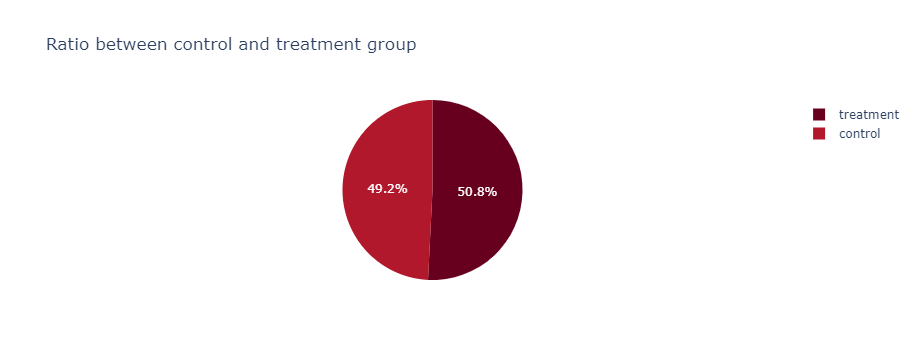

In [194]:
values = np.array([control_prop,treatment_prop])
names = np.array(['control','treatment'])
px.pie(data_frame =df2,names = names ,values = values ,labels ={"group":'control',"group":'treatment'},title = 'Ratio between control and treatment group',color_discrete_sequence=px.colors.sequential.RdBu)

<span style = 'color:blue;'> We can see that the proportion of two pages are nearly equal so that data isn't biased to any page </span>

In [195]:
prop_converted = df2.query("converted == 1").shape[0]/df2.shape[0]
prop_converted # proportion of people who converted

0.12818003913894324

In [196]:
prop_not_conv = df2.query("converted == 0").shape[0]/df2.shape[0]
prop_not_conv# proportion of people who didn't convert

0.8718199608610567

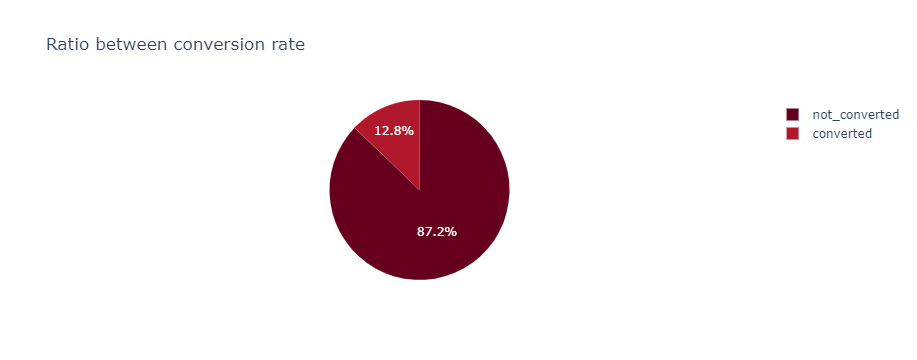

In [197]:
columns =np.array([prop_converted,prop_not_conv])
name = np.array(['converted','not_converted'])
px.pie(data_frame = df2 , names = name,title = 'Ratio between conversion rate',values= columns,color_discrete_sequence=px.colors.sequential.RdBu)

<span style = 'color:blue;'>We could see that ratio of people who converts is less than people who didn't convert. </span>

In [198]:
control_conv_prop = (df2.query("group == 'control'")['converted']==1).mean()
control_conv_prop# Proportion of people who are in control group and converted

0.12127236580516898

In [199]:
treatment_conv_prop = (df2.query("group == 'treatment'")['converted']==1).mean()
treatment_conv_prop # Proportion of people who are in treatment group and converted

0.1348747591522158

In [200]:
obs_diff = control_conv_prop - treatment_conv_prop # Difference between conversion rate of two pages.
obs_diff #Both pages are nearly equal

-0.013602393347046826

<span style = 'color:blue;'> We could see that the coversion rate of control group is higher than treatment group by 0.01 so they are nearly equal to each other.</span>

# PartII A/B test 

1 - The null hypothesis should be  mean of new - mean of old <= 0  
The Alternative hypothesis should be mean of new - mean of old > 0 

In [201]:
df2.head()

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0


In [202]:
# conversion rate of new page 
Pnew = (df2.query("converted == 1")).shape[0]/df2.shape[0]
Pnew

0.12818003913894324

In [203]:
# conversion rate of old page 
Pold = (df2.query("converted == 1")).shape[0]/df2.shape[0]
Pold

0.12818003913894324

In [204]:
Nnew = df2.query("group == 'treatment'").shape[0]
Nnew # Number of users in new page

1038

In [205]:
Nold = df2.query("group == 'control'").shape[0]
Nold # Number of users in old page

1006

 Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [206]:
new_page_converted = np.random.choice([1,0],size = Nnew, replace = True ,p = [Pnew,(1-Pnew)])
new_page_converted.mean()

0.1396917148362235

 Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [207]:
old_page_converted = np.random.choice([1,0],size = Nold,replace = True , p =[Pold,(1-Pold)])
old_page_converted.mean()

0.1272365805168986

In [208]:
P_diff =[]
'''bootstrab the two pages in 10000 iteration and find the mean differences and put the result in the list P_diff'''
new_converted_simulation = np.random.binomial(Nnew, Pnew, 10000)/Nnew 
old_converted_simulation = np.random.binomial(Nold, Pold, 10000)/Nold 
P_diff = new_converted_simulation - old_converted_simulation

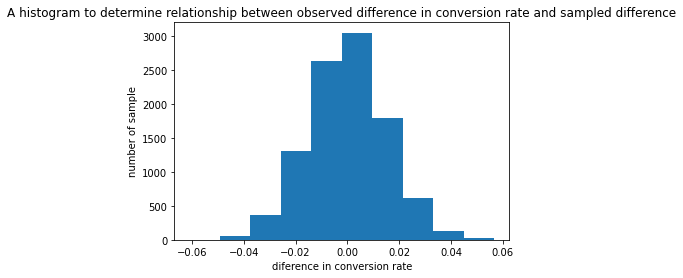

In [209]:
plt.hist(P_diff)
plt.title('A histogram to determine relationship between observed difference in conversion rate and sampled difference')
plt.xlabel('diference in conversion rate')
plt.ylabel('number of sample');

In [210]:
actual_new =(df2.query("group == 'treatment'")['converted'] == 1).mean()
actual_old = (df2.query("group == 'control'")['converted'] == 1).mean()
actual_diff = actual_old - actual_new
actual_diff # the actual diffrence in conversion rate between two pages .

-0.013602393347046826

In [211]:
null_value = np.random.normal(0,P_diff.std(),P_diff.size) # Normal distribution for null values using std of p_diff array and it's size.

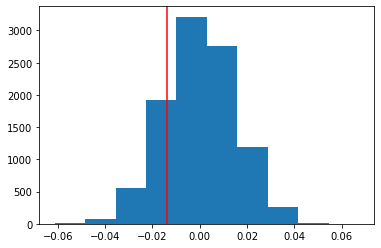

In [212]:
plt.hist(null_value)
plt.axvline(actual_diff,color = 'red'); # red line represents actual difference in conversion rate between two page.

<span style='color:blue;'>This is normal distribution for the null values and red line represents the observed statistics (actual difference).</span>

In [213]:
Pvalue = (null_value > actual_diff).mean()
Pvalue # calculating the P-value

0.8239

A p-value measures the probability of obtaining the observed results, assuming that the null hypothesis is true.
Since P-value > Type I error (alpha = 0.05) therefore we fail to reject the null hypothesis . So, according to the null hypothesis 
two pages are equal or less than zero so the new_page is better than old_page in that case.

In [214]:
import statsmodels.api as sm

In [215]:
convert_old = (df2.query("landing_page == 'old_page'")['converted']==1).sum() # Total conversion for old page.
convert_new = (df2.query("landing_page == 'new_page'")['converted']==1).sum() # Total conversion for new page.
n_old = df2.query("group == 'control'").shape[0] # Number of old page.
n_new = df2.query("group == 'treatment'").shape[0] # Number of new page.

In [216]:
n_old , n_new

(1006, 1038)

In [217]:
convert_new , convert_old

(122, 140)

In [218]:
Z_score , P_value = sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old],alternative = 'larger')

In [219]:
Z_score , P_value

(-1.462567983321405, 0.9282071853292702)

<span style="color: red;">P_value here agree with the previous finding , So we fail to reject the Null</span>

# PartIII Regression

In [220]:
df2.head()

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0


## a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logestic regression

### b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [221]:
df2['intercept'] = 1 # The intercept column.
df2[['control','ab_page']]=pd.get_dummies(df2['group']) # adding control and ab_page column which represents dummy varibles in group column. 

In [222]:
df2.drop(labels = ['control'],axis = 1 , inplace = True) #deleting control dummy 

In [223]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
22,767017,2017-01-12 22:58:14.991443,control,new_page,0,1,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0,1,0
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0,1,1
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0,1,1
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0,1,1


we could see that in ab_page column it's 1 if it's treatment and 0 for control

In [224]:
lm = sm.OLS(df2['converted'],df2[['intercept','ab_page']]) # Fitting our Linear model, we predict conversion rate based on ab_page column and the intercept column.
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8454
Date:                Fri, 22 Apr 2022   Prob (F-statistic):              0.358
Time:                        15:10:46   Log-Likelihood:                -660.18
No. Observations:                2044   AIC:                             1324.
Df Residuals:                    2042   BIC:                             1336.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1213      0.011     11.503      0.000       0.101       0.142
ab_page        0.0136      0.015      0.919      0.358      -0.015       0.043
==============================================================================
Omnibus:                      832.178   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2422.919
Skew:                           2.223   Prob(JB):                         0.00
Kurtosis:                       5.946   Cond. No.                         2.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

P_value = 0.358 , It differs from the P_value in Part two because here the P_value indicates whether or not the predictor values is related to response variable or not. Here the P_value is large so the predictor values are not associated with the changes in the response variable.Since the P_value > alpha so the new_page is not statistically significant.
In this section it was two sided test while in part 2 it was one sided test. 


<span style = 'color:blue;'> H0: pnew−pold=0
****************H1: pnew−pold≠0 </span>

### f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Adding other factors into regression model is good idea as we can 

There are some problems may face us while adding factors to regression model as Multicorllinearity where variables must be related to the predictor only not to each other

### g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

## Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [225]:
country_df = pd.read_csv('countries.csv') # Importing countries file

In [226]:
country_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [227]:
new_df = country_df.set_index('user_id').join(df2.set_index('user_id'), how='inner') #joinin two tables together

In [228]:
new_df.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
842181,US,2017-01-11 06:29:39.044997,treatment,old_page,0,1,1
942678,US,2017-01-14 03:37:44.631055,treatment,old_page,0,1,1
795558,CA,2017-01-08 19:11:06.575857,control,new_page,1,1,0
886346,US,2017-01-03 20:53:13.088981,control,new_page,0,1,0
886323,UK,2017-01-11 16:23:13.412988,control,new_page,0,1,0


In [229]:
new_df[['CA','UK','US']] = pd.get_dummies(new_df['country']) # Creating the dummy variables

In [230]:
new_df.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
842181,US,2017-01-11 06:29:39.044997,treatment,old_page,0,1,1,0,0,1
942678,US,2017-01-14 03:37:44.631055,treatment,old_page,0,1,1,0,0,1
795558,CA,2017-01-08 19:11:06.575857,control,new_page,1,1,0,1,0,0
886346,US,2017-01-03 20:53:13.088981,control,new_page,0,1,0,0,0,1
886323,UK,2017-01-11 16:23:13.412988,control,new_page,0,1,0,0,1,0


In [231]:
lm2 = sm.Logit(new_df['converted'],new_df[['intercept','CA','UK','ab_page']]) # We dropped the US column and intercept is used instead of it.
results = lm2.fit() # fitting our new model, we predict conversion rate based on ab_page, UK , CA and intercept columns.
results.summary()

Optimization terminated successfully.
         Current function value: 0.382094
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                 2044
Model:                          Logit   Df Residuals:                     2040
Method:                           MLE   Df Model:                            3
Date:                Fri, 22 Apr 2022   Pseudo R-squ.:                0.002137
Time:                        15:10:53   Log-Likelihood:                -781.00
converged:                       True   LL-Null:                       -782.67
Covariance Type:            nonrobust   LLR p-value:                    0.3414
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0044      0.107    -18.816      0.000      -2.213      -1.796
CA             0.4309      0.266      1.621      0.105      -0.090       0.952
UK            -0.0060      0.157     -0.038      0.970      -0.313       0.301
ab_page        0.1214      0.133      0.915      0.360      -0.139       0.381
==============================================================================
"""

## h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

## Provide the summary results, and your conclusions based on the results.

In [232]:
new_df['interaction_UK'] = new_df['UK'] * new_df['ab_page'] # Interaction between UK and ab_page column

In [233]:
new_df['interaction_Ca'] = new_df['CA'] * new_df['ab_page'] # Interaction between CA and ab_page column

Fit linear model and obtain the results

In [234]:
lm3 = sm.Logit(new_df['converted'],new_df[['intercept','CA','UK','ab_page','interaction_Ca','interaction_UK']]) # adding interaction columns to our model
result3 = lm3.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.381080
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                 2044
Model:                          Logit   Df Residuals:                     2038
Method:                           MLE   Df Model:                            5
Date:                Fri, 22 Apr 2022   Pseudo R-squ.:                0.004786
Time:                        15:10:56   Log-Likelihood:                -778.93
converged:                       True   LL-Null:                       -782.67
Covariance Type:            nonrobust   LLR p-value:                    0.1866
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -2.0667      0.119    -17.306      0.000      -2.301      -1.833
CA                 0.2284      0.424      0.539      0.590      -0.603       1.060
UK                 0.2749      0.216      1.273      0.203      -0.148       0.698
ab_page            0.2361      0.160      1.471      0.141      -0.078       0.551
interaction_Ca     0.3494      0.546      0.640      0.522      -0.721       1.420
interaction_UK    -0.5690      0.316     -1.803      0.071      -1.188       0.050
==================================================================================
"""

<span style = 'color:blue;'> Since two columns of interactions have p_value of 0.522 and 0.071 which is greater than type I Error then we fail to reject the null, since null isn't statisically significant </span> . 

# Conclusion

<span style = 'color:blue;'> H0: pnew−pold=0
****************H1: pnew−pold≠0 </span>
We Fail to reject Null Hypothesis as there is no significant difference in conversion rates. We can reject alternate hypothesis.Since P_value of ab_page = 0.141 is greater than Alpha value or the type I error (0.005),So The new page is prefered than old page.

